# Work in progress

In [543]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import scipy.io
from pymatreader import read_mat
from scipy.io import loadmat
from sklearn.preprocessing import LabelEncoder

np.random.seed(40)

In [547]:
data = pd.read_csv('./dataset/combined_data.csv')
#dropping the columns that are not required like the filepath
data = data.drop(['matFilePath'], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3600000 entries, 0 to 3599999
Data columns (total 13 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Timestamps            float64
 1   Motor1Cmd             float64
 2   Motor2Cmd             float64
 3   Motor3Cmd             float64
 4   Motor4Cmd             float64
 5   Motor5Cmd             int64  
 6   DesiredTrajectory-x   float64
 7   DesiredTrajectory-y   float64
 8   DesiredTrajectory-z   float64
 9   RealizedTrajectory-x  float64
 10  RealizedTrajectory-y  float64
 11  RealizedTrajectory-z  float64
 12  Target                object 
dtypes: float64(11), int64(1), object(1)
memory usage: 357.1+ MB


In [545]:
df = data.copy()

df["Target"].unique()

array(['Healthy', 'Motor_1_Steady_state_error', 'Motor_1_Stuck',
       'Motor_2_Steady_state_error', 'Motor_2_Stuck',
       'Motor_3_Steady_state_error', 'Motor_3_Stuck',
       'Motor_4_Steady_state_error', 'Motor_4_Stuck'], dtype=object)

In [546]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Check if MPS is available and set the device
device = torch.device("cpu") #CPU as LSTM, sequential 
logging.info(f"Using device: {device}")

# Define the features and target
X = df.drop(columns=['Target', 'Timestamps'])
y = df['Target']
timestamps = df['Timestamps']

# Apply StandardScaler to the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Group the data by sequences based on the Timestamps column
sequences = []
current_sequence = []
current_labels = []
for i in range(len(X_scaled)):
    current_sequence.append(X_scaled[i])
    current_labels.append(y.iloc[i])
    if i < len(X_scaled) - 1 and timestamps.iloc[i + 1] == 0.0:
        sequences.append((current_sequence, current_labels))
        current_sequence = []
        current_labels = []
if current_sequence:
    sequences.append((current_sequence, current_labels))

# Ensure each sequence has the same length
sequence_length = max(len(seq[0]) for seq in sequences)
num_features = X.shape[1]

# Pad sequences to make them uniform in length
padded_sequences = []
padded_labels = []
for seq, labels in sequences:
    if len(seq) < sequence_length:
        padding = [[0] * num_features] * (sequence_length - len(seq))
        seq.extend(padding)
        labels.extend([labels[-1]] * (sequence_length - len(labels)))  # Pad labels with the last label
    padded_sequences.append(seq)
    padded_labels.append(labels)  # Use all labels for the sequence

# Convert sequences to a DataFrame
X_padded = np.array(padded_sequences)
y_padded = np.array(padded_labels)

# Flatten the labels to match the number of sequences
y_padded_flat = y_padded[:, 0]  # Use the first label of each sequence for simplicity

# Split the dataset
training_ratio = 0.9
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_padded_flat, test_size=(1 - training_ratio), stratify=y_padded_flat)

# One-hot encode the target variable
encoder = OneHotEncoder(sparse_output=False)
y_train_encoded = encoder.fit_transform(y_train.reshape(-1, 1))
y_test_encoded = encoder.transform(y_test.reshape(-1, 1))

# Ensure the reshaped data has the correct number of samples
assert X_train.shape[0] == y_train_encoded.shape[0], "Mismatch in number of training samples"
assert X_test.shape[0] == y_test_encoded.shape[0], "Mismatch in number of test samples"

# Convert data to PyTorch tensors and move to device
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.float32).to(device)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the LSTM model
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMClassifier, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(0.1)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x = self.dropout(x)
        x, _ = self.lstm2(x)
        x = self.fc(x[:, -1, :])
        return x

# Hyperparameters
input_size = num_features  # Number of features per time step
hidden_size = 100
output_size = y_train_encoded.shape[1]
num_epochs = 30
learning_rate = 0.001
early_stopping_patience = 5

# Initialize the model, loss function, and optimizer
model = LSTMClassifier(input_size, hidden_size, output_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop with early stopping
history = {'train_loss': [], 'val_loss': [], 'grad_norm': []}
best_loss = float('inf')
epochs_no_improve = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    grad_norms = []
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, torch.max(y_batch, 1)[1])
        loss.backward()

        # Calculate gradient norm
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        grad_norms.append(grad_norm.item())

        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    avg_grad_norm = np.mean(grad_norms)
    history['train_loss'].append(avg_train_loss)
    history['grad_norm'].append(avg_grad_norm)

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, torch.max(y_batch, 1)[1])
            val_loss += loss.item()

    avg_val_loss = val_loss / len(test_loader)
    history['val_loss'].append(avg_val_loss)

    info_str = (f"Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, "
                f"Val Loss: {avg_val_loss:.4f}, Grad Norm: {avg_grad_norm:.4f}")
    logging.info(info_str)
    print(info_str)

    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        logging.info("Best model saved.")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= early_stopping_patience:
        logging.info("Early stopping triggered.")
        break

# Plot training curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history['grad_norm'], label='Grad Norm')
plt.xlabel('Epoch')
plt.ylabel('Grad Norm')
plt.legend()
plt.tight_layout()
plt.show()

# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    y_pred_classes = torch.argmax(y_pred, dim=1)
    y_test_classes = torch.argmax(y_test_tensor, dim=1)

# Calculate metrics
accuracy = (y_pred_classes == y_test_classes).sum().item() / len(y_test_classes)
print(f'Accuracy: {accuracy:.4f}')
print("Classification Report:\n", classification_report(y_test_classes, y_pred_classes))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
print("Confusion Matrix:\n", conf_matrix)

# F1 Score
f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')
print("F1 Score:", f1)

# Plot Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


2025-02-23 11:03:23,530 - INFO - Using device: cpu


KeyboardInterrupt: 

Another LSTM layer

2025-02-22 19:31:27,159 - INFO - Using device: cpu
2025-02-22 19:32:44,331 - INFO - Epoch 1: Train Loss: 2.1567, Val Loss: 2.0832, Grad Norm: 0.5382
2025-02-22 19:32:44,333 - INFO - Best model saved.


Epoch 1: Train Loss: 2.1567, Val Loss: 2.0832, Grad Norm: 0.5382


2025-02-22 19:33:51,942 - INFO - Epoch 2: Train Loss: 1.9916, Val Loss: 1.9112, Grad Norm: 1.3401
2025-02-22 19:33:51,944 - INFO - Best model saved.


Epoch 2: Train Loss: 1.9916, Val Loss: 1.9112, Grad Norm: 1.3401


2025-02-22 19:34:59,939 - INFO - Epoch 3: Train Loss: 1.9313, Val Loss: 1.8504, Grad Norm: 1.1790
2025-02-22 19:34:59,941 - INFO - Best model saved.


Epoch 3: Train Loss: 1.9313, Val Loss: 1.8504, Grad Norm: 1.1790


2025-02-22 19:36:07,648 - INFO - Epoch 4: Train Loss: 1.8880, Val Loss: 1.8817, Grad Norm: 2.0602


Epoch 4: Train Loss: 1.8880, Val Loss: 1.8817, Grad Norm: 2.0602


2025-02-22 19:37:15,254 - INFO - Epoch 5: Train Loss: 1.8435, Val Loss: 1.8712, Grad Norm: 5.0452


Epoch 5: Train Loss: 1.8435, Val Loss: 1.8712, Grad Norm: 5.0452


2025-02-22 19:38:22,687 - INFO - Epoch 6: Train Loss: 1.8267, Val Loss: 1.8708, Grad Norm: 2.3198


Epoch 6: Train Loss: 1.8267, Val Loss: 1.8708, Grad Norm: 2.3198


2025-02-22 19:39:30,569 - INFO - Epoch 7: Train Loss: 1.8934, Val Loss: 1.8569, Grad Norm: 3.9693


Epoch 7: Train Loss: 1.8934, Val Loss: 1.8569, Grad Norm: 3.9693


2025-02-22 19:40:39,624 - INFO - Epoch 8: Train Loss: 1.8025, Val Loss: 1.7225, Grad Norm: 2.5353
2025-02-22 19:40:39,626 - INFO - Best model saved.


Epoch 8: Train Loss: 1.8025, Val Loss: 1.7225, Grad Norm: 2.5353


2025-02-22 19:41:48,137 - INFO - Epoch 9: Train Loss: 1.6959, Val Loss: 1.6082, Grad Norm: 4.3663
2025-02-22 19:41:48,138 - INFO - Best model saved.


Epoch 9: Train Loss: 1.6959, Val Loss: 1.6082, Grad Norm: 4.3663


2025-02-22 19:42:56,923 - INFO - Epoch 10: Train Loss: 1.5838, Val Loss: 1.5278, Grad Norm: 5.3234
2025-02-22 19:42:56,926 - INFO - Best model saved.


Epoch 10: Train Loss: 1.5838, Val Loss: 1.5278, Grad Norm: 5.3234


2025-02-22 19:44:05,983 - INFO - Epoch 11: Train Loss: 1.4985, Val Loss: 1.3916, Grad Norm: 6.5627
2025-02-22 19:44:05,985 - INFO - Best model saved.


Epoch 11: Train Loss: 1.4985, Val Loss: 1.3916, Grad Norm: 6.5627


2025-02-22 19:45:14,518 - INFO - Epoch 12: Train Loss: 1.4170, Val Loss: 1.3344, Grad Norm: 6.2873
2025-02-22 19:45:14,520 - INFO - Best model saved.


Epoch 12: Train Loss: 1.4170, Val Loss: 1.3344, Grad Norm: 6.2873


2025-02-22 19:46:23,010 - INFO - Epoch 13: Train Loss: 1.3684, Val Loss: 1.2894, Grad Norm: 8.6059
2025-02-22 19:46:23,012 - INFO - Best model saved.


Epoch 13: Train Loss: 1.3684, Val Loss: 1.2894, Grad Norm: 8.6059


2025-02-22 19:47:31,976 - INFO - Epoch 14: Train Loss: 1.2796, Val Loss: 1.2803, Grad Norm: 8.3313
2025-02-22 19:47:31,977 - INFO - Best model saved.


Epoch 14: Train Loss: 1.2796, Val Loss: 1.2803, Grad Norm: 8.3313


2025-02-22 19:48:40,188 - INFO - Epoch 15: Train Loss: 1.2418, Val Loss: 1.2158, Grad Norm: 9.6056
2025-02-22 19:48:40,189 - INFO - Best model saved.


Epoch 15: Train Loss: 1.2418, Val Loss: 1.2158, Grad Norm: 9.6056


2025-02-22 19:49:48,985 - INFO - Epoch 16: Train Loss: 1.2331, Val Loss: 1.2178, Grad Norm: 10.7983


Epoch 16: Train Loss: 1.2331, Val Loss: 1.2178, Grad Norm: 10.7983


2025-02-22 19:50:57,272 - INFO - Epoch 17: Train Loss: 1.2221, Val Loss: 1.2171, Grad Norm: 8.9075


Epoch 17: Train Loss: 1.2221, Val Loss: 1.2171, Grad Norm: 8.9075


2025-02-22 19:52:03,717 - INFO - Epoch 18: Train Loss: 1.1942, Val Loss: 1.2078, Grad Norm: 9.1243
2025-02-22 19:52:03,721 - INFO - Best model saved.


Epoch 18: Train Loss: 1.1942, Val Loss: 1.2078, Grad Norm: 9.1243


2025-02-22 19:53:10,896 - INFO - Epoch 19: Train Loss: 1.2273, Val Loss: 1.1815, Grad Norm: 9.2417
2025-02-22 19:53:10,899 - INFO - Best model saved.


Epoch 19: Train Loss: 1.2273, Val Loss: 1.1815, Grad Norm: 9.2417


2025-02-22 19:54:19,237 - INFO - Epoch 20: Train Loss: 1.1593, Val Loss: 1.1234, Grad Norm: 11.1500
2025-02-22 19:54:19,239 - INFO - Best model saved.


Epoch 20: Train Loss: 1.1593, Val Loss: 1.1234, Grad Norm: 11.1500


2025-02-22 19:55:25,756 - INFO - Epoch 21: Train Loss: 1.1643, Val Loss: 1.2601, Grad Norm: 10.0557


Epoch 21: Train Loss: 1.1643, Val Loss: 1.2601, Grad Norm: 10.0557


2025-02-22 19:56:33,733 - INFO - Epoch 22: Train Loss: 1.1478, Val Loss: 1.1941, Grad Norm: 9.9852


Epoch 22: Train Loss: 1.1478, Val Loss: 1.1941, Grad Norm: 9.9852


2025-02-22 19:57:42,696 - INFO - Epoch 23: Train Loss: 1.1461, Val Loss: 1.3039, Grad Norm: 10.2938


Epoch 23: Train Loss: 1.1461, Val Loss: 1.3039, Grad Norm: 10.2938


2025-02-22 19:58:51,362 - INFO - Epoch 24: Train Loss: 1.1337, Val Loss: 1.2161, Grad Norm: 9.8267


Epoch 24: Train Loss: 1.1337, Val Loss: 1.2161, Grad Norm: 9.8267


2025-02-22 20:00:00,537 - INFO - Epoch 25: Train Loss: 1.1252, Val Loss: 1.1422, Grad Norm: 11.2789
2025-02-22 20:00:00,538 - INFO - Early stopping triggered.


Epoch 25: Train Loss: 1.1252, Val Loss: 1.1422, Grad Norm: 11.2789


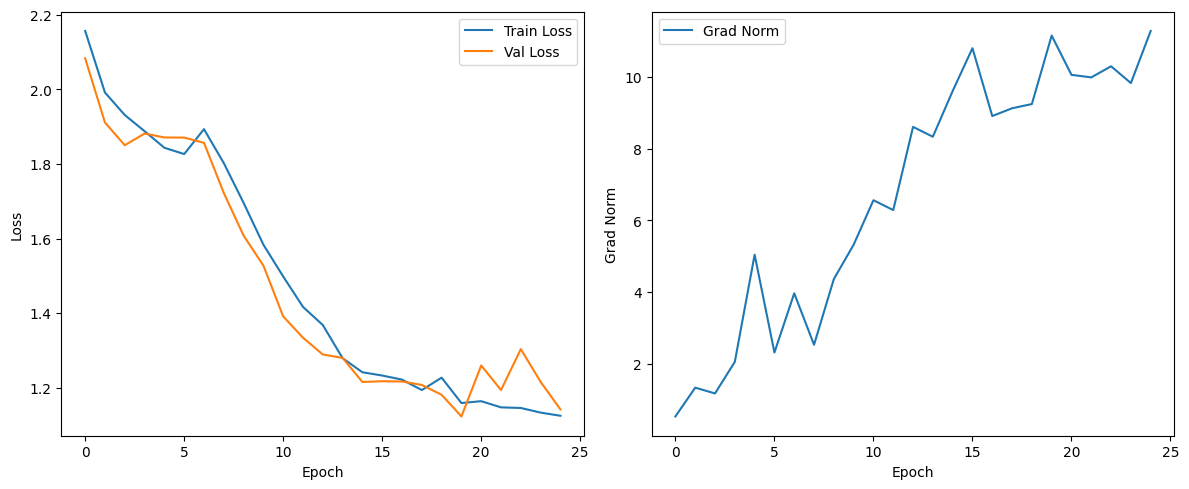

Accuracy: 0.5306
Classification Report:
               precision    recall  f1-score   support

           0       0.45      0.57      0.51        40
           1       0.61      0.68      0.64        40
           2       0.92      0.82      0.87        40
           3       0.50      0.30      0.38        40
           4       0.91      0.50      0.65        40
           5       0.42      0.60      0.49        40
           6       0.47      0.68      0.56        40
           7       0.35      0.42      0.38        40
           8       0.40      0.20      0.27        40

    accuracy                           0.53       360
   macro avg       0.56      0.53      0.53       360
weighted avg       0.56      0.53      0.53       360

Confusion Matrix:
 [[23  4  0  0  0  0  0 13  0]
 [ 8 27  3  0  0  1  0  1  0]
 [ 1  6 33  0  0  0  0  0  0]
 [ 0  0  0 12  0 11  8  3  6]
 [ 0  0  0  0 20  0 18  2  0]
 [ 0  2  0  5  0 24  0  4  5]
 [ 2  0  0  3  2  5 27  0  1]
 [14  4  0  0  0  5  0 17

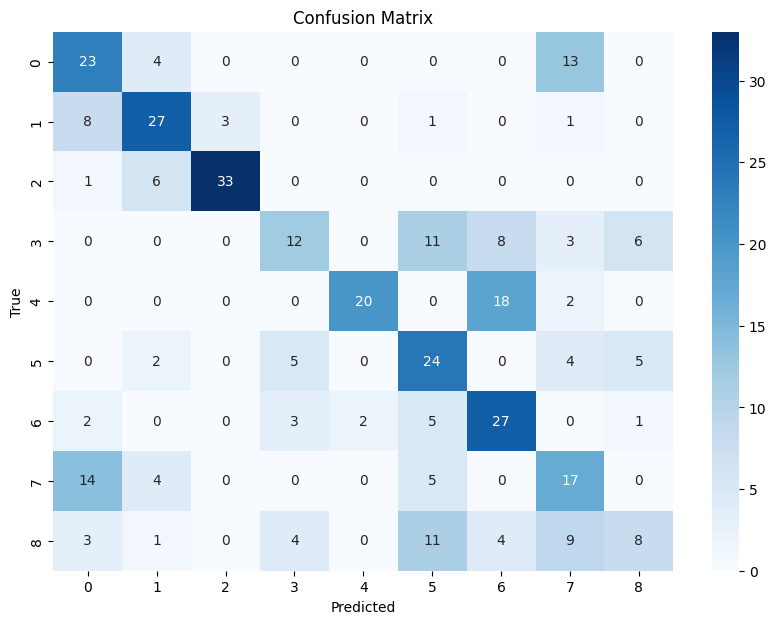

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Check if MPS is available and set the device
device = torch.device("cpu") #CPU as LSTM, sequential 
logging.info(f"Using device: {device}")

# Define the features and target
X = df.drop(columns=['Target', 'Timestamps'])
y = df['Target']
timestamps = df['Timestamps']

# Apply StandardScaler to the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Group the data by sequences based on the Timestamps column
sequences = []
current_sequence = []
current_labels = []
for i in range(len(X_scaled)):
    current_sequence.append(X_scaled[i])
    current_labels.append(y.iloc[i])
    if i < len(X_scaled) - 1 and timestamps.iloc[i + 1] == 0.0:
        sequences.append((current_sequence, current_labels))
        current_sequence = []
        current_labels = []
if current_sequence:
    sequences.append((current_sequence, current_labels))

# Ensure each sequence has the same length
sequence_length = max(len(seq[0]) for seq in sequences)
num_features = X.shape[1]

# Pad sequences to make them uniform in length
padded_sequences = []
padded_labels = []
for seq, labels in sequences:
    if len(seq) < sequence_length:
        padding = [[0] * num_features] * (sequence_length - len(seq))
        seq.extend(padding)
        labels.extend([labels[-1]] * (sequence_length - len(labels)))  # Pad labels with the last label
    padded_sequences.append(seq)
    padded_labels.append(labels)  # Use all labels for the sequence

# Convert sequences to a DataFrame
X_padded = np.array(padded_sequences)
y_padded = np.array(padded_labels)

# Flatten the labels to match the number of sequences
y_padded_flat = y_padded[:, 0]  # Use the first label of each sequence for simplicity

# Split the dataset
training_ratio = 0.9
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_padded_flat, test_size=(1 - training_ratio), stratify=y_padded_flat)

# One-hot encode the target variable
encoder = OneHotEncoder(sparse_output=False)
y_train_encoded = encoder.fit_transform(y_train.reshape(-1, 1))
y_test_encoded = encoder.transform(y_test.reshape(-1, 1))

# Ensure the reshaped data has the correct number of samples
assert X_train.shape[0] == y_train_encoded.shape[0], "Mismatch in number of training samples"
assert X_test.shape[0] == y_test_encoded.shape[0], "Mismatch in number of test samples"

# Convert data to PyTorch tensors and move to device
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.float32).to(device)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMClassifier, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.dropout1 = nn.Dropout(0.1)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.dropout2 = nn.Dropout(0.1)
        self.lstm3 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        #self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x = self.dropout1(x)
        x, _ = self.lstm2(x)
        x = self.dropout2(x)
        x, _ = self.lstm3(x)
        x = self.fc(x[:, -1, :])
        #x = self.softmax(x)
        return x

# Hyperparameters
input_size = num_features  # Number of features per time step
hidden_size = 100
output_size = y_train_encoded.shape[1]
num_epochs = 30
learning_rate = 0.001
early_stopping_patience = 5

# Initialize the model, loss function, and optimizer
model = LSTMClassifier(input_size, hidden_size, output_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop with early stopping
history = {'train_loss': [], 'val_loss': [], 'grad_norm': []}
best_loss = float('inf')
epochs_no_improve = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    grad_norms = []
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, torch.max(y_batch, 1)[1])
        loss.backward()

        # Calculate gradient norm
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        grad_norms.append(grad_norm.item())

        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    avg_grad_norm = np.mean(grad_norms)
    history['train_loss'].append(avg_train_loss)
    history['grad_norm'].append(avg_grad_norm)

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, torch.max(y_batch, 1)[1])
            val_loss += loss.item()

    avg_val_loss = val_loss / len(test_loader)
    history['val_loss'].append(avg_val_loss)

    info_str = (f"Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, "
                f"Val Loss: {avg_val_loss:.4f}, Grad Norm: {avg_grad_norm:.4f}")
    logging.info(info_str)
    print(info_str)

    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        logging.info("Best model saved.")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= early_stopping_patience:
        logging.info("Early stopping triggered.")
        break

# Plot training curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history['grad_norm'], label='Grad Norm')
plt.xlabel('Epoch')
plt.ylabel('Grad Norm')
plt.legend()
plt.tight_layout()
plt.show()

# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    y_pred_classes = torch.argmax(y_pred, dim=1)
    y_test_classes = torch.argmax(y_test_tensor, dim=1)

# Calculate metrics
accuracy = (y_pred_classes == y_test_classes).sum().item() / len(y_test_classes)
print(f'Accuracy: {accuracy:.4f}')
print("Classification Report:\n", classification_report(y_test_classes, y_pred_classes))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
print("Confusion Matrix:\n", conf_matrix)

# F1 Score
f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')
print("F1 Score:", f1)

# Plot Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# With 20% split

2025-02-22 22:48:32,565 - INFO - Using device: cpu
2025-02-22 22:49:46,601 - INFO - Epoch 1: Train Loss: 2.1900, Val Loss: 2.1311, Grad Norm: 0.2466
2025-02-22 22:49:46,606 - INFO - Best model saved.


Epoch 1: Train Loss: 2.1900, Val Loss: 2.1311, Grad Norm: 0.2466


2025-02-22 22:50:47,479 - INFO - Epoch 2: Train Loss: 2.0909, Val Loss: 2.0614, Grad Norm: 1.1169
2025-02-22 22:50:47,481 - INFO - Best model saved.


Epoch 2: Train Loss: 2.0909, Val Loss: 2.0614, Grad Norm: 1.1169


2025-02-22 22:51:47,725 - INFO - Epoch 3: Train Loss: 2.0119, Val Loss: 1.9296, Grad Norm: 2.1868
2025-02-22 22:51:47,729 - INFO - Best model saved.


Epoch 3: Train Loss: 2.0119, Val Loss: 1.9296, Grad Norm: 2.1868


2025-02-22 22:52:46,081 - INFO - Epoch 4: Train Loss: 1.8883, Val Loss: 1.7380, Grad Norm: 2.2261
2025-02-22 22:52:46,083 - INFO - Best model saved.


Epoch 4: Train Loss: 1.8883, Val Loss: 1.7380, Grad Norm: 2.2261


2025-02-22 22:53:45,370 - INFO - Epoch 5: Train Loss: 1.7294, Val Loss: 1.6680, Grad Norm: 3.8364
2025-02-22 22:53:45,373 - INFO - Best model saved.


Epoch 5: Train Loss: 1.7294, Val Loss: 1.6680, Grad Norm: 3.8364


2025-02-22 22:54:44,524 - INFO - Epoch 6: Train Loss: 1.6096, Val Loss: 1.5666, Grad Norm: 5.7509
2025-02-22 22:54:44,527 - INFO - Best model saved.


Epoch 6: Train Loss: 1.6096, Val Loss: 1.5666, Grad Norm: 5.7509


2025-02-22 22:55:42,299 - INFO - Epoch 7: Train Loss: 1.5468, Val Loss: 1.4466, Grad Norm: 6.3499
2025-02-22 22:55:42,301 - INFO - Best model saved.


Epoch 7: Train Loss: 1.5468, Val Loss: 1.4466, Grad Norm: 6.3499


2025-02-22 22:56:39,620 - INFO - Epoch 8: Train Loss: 1.4640, Val Loss: 1.3844, Grad Norm: 5.9838
2025-02-22 22:56:39,621 - INFO - Best model saved.


Epoch 8: Train Loss: 1.4640, Val Loss: 1.3844, Grad Norm: 5.9838


2025-02-22 22:57:37,659 - INFO - Epoch 9: Train Loss: 1.3875, Val Loss: 1.3706, Grad Norm: 6.7741
2025-02-22 22:57:37,662 - INFO - Best model saved.


Epoch 9: Train Loss: 1.3875, Val Loss: 1.3706, Grad Norm: 6.7741


2025-02-22 22:58:36,898 - INFO - Epoch 10: Train Loss: 1.3500, Val Loss: 1.3361, Grad Norm: 10.0253
2025-02-22 22:58:36,907 - INFO - Best model saved.


Epoch 10: Train Loss: 1.3500, Val Loss: 1.3361, Grad Norm: 10.0253


2025-02-22 22:59:34,538 - INFO - Epoch 11: Train Loss: 1.3055, Val Loss: 1.3006, Grad Norm: 8.6103
2025-02-22 22:59:34,542 - INFO - Best model saved.


Epoch 11: Train Loss: 1.3055, Val Loss: 1.3006, Grad Norm: 8.6103


2025-02-22 23:00:31,955 - INFO - Epoch 12: Train Loss: 1.2865, Val Loss: 1.2352, Grad Norm: 11.1360
2025-02-22 23:00:31,959 - INFO - Best model saved.


Epoch 12: Train Loss: 1.2865, Val Loss: 1.2352, Grad Norm: 11.1360


2025-02-22 23:01:29,317 - INFO - Epoch 13: Train Loss: 1.2752, Val Loss: 1.2427, Grad Norm: 9.5345


Epoch 13: Train Loss: 1.2752, Val Loss: 1.2427, Grad Norm: 9.5345


2025-02-22 23:02:28,046 - INFO - Epoch 14: Train Loss: 1.2350, Val Loss: 1.2679, Grad Norm: 8.8568


Epoch 14: Train Loss: 1.2350, Val Loss: 1.2679, Grad Norm: 8.8568


2025-02-22 23:03:27,165 - INFO - Epoch 15: Train Loss: 1.2166, Val Loss: 1.2155, Grad Norm: 10.1819
2025-02-22 23:03:27,170 - INFO - Best model saved.


Epoch 15: Train Loss: 1.2166, Val Loss: 1.2155, Grad Norm: 10.1819


2025-02-22 23:04:25,260 - INFO - Epoch 16: Train Loss: 1.1880, Val Loss: 1.1950, Grad Norm: 9.4516
2025-02-22 23:04:25,263 - INFO - Best model saved.


Epoch 16: Train Loss: 1.1880, Val Loss: 1.1950, Grad Norm: 9.4516


2025-02-22 23:05:23,803 - INFO - Epoch 17: Train Loss: 1.1747, Val Loss: 1.2888, Grad Norm: 10.9065


Epoch 17: Train Loss: 1.1747, Val Loss: 1.2888, Grad Norm: 10.9065


2025-02-22 23:06:22,316 - INFO - Epoch 18: Train Loss: 1.1738, Val Loss: 1.1942, Grad Norm: 9.8945
2025-02-22 23:06:22,320 - INFO - Best model saved.


Epoch 18: Train Loss: 1.1738, Val Loss: 1.1942, Grad Norm: 9.8945


2025-02-22 23:07:20,502 - INFO - Epoch 19: Train Loss: 1.1686, Val Loss: 1.2170, Grad Norm: 10.7613


Epoch 19: Train Loss: 1.1686, Val Loss: 1.2170, Grad Norm: 10.7613


2025-02-22 23:08:18,558 - INFO - Epoch 20: Train Loss: 1.1593, Val Loss: 1.1529, Grad Norm: 10.7455
2025-02-22 23:08:18,561 - INFO - Best model saved.


Epoch 20: Train Loss: 1.1593, Val Loss: 1.1529, Grad Norm: 10.7455


2025-02-22 23:09:16,965 - INFO - Epoch 21: Train Loss: 1.1594, Val Loss: 1.1681, Grad Norm: 9.0576


Epoch 21: Train Loss: 1.1594, Val Loss: 1.1681, Grad Norm: 9.0576


2025-02-22 23:10:14,921 - INFO - Epoch 22: Train Loss: 1.1333, Val Loss: 1.1155, Grad Norm: 11.1369
2025-02-22 23:10:14,925 - INFO - Best model saved.


Epoch 22: Train Loss: 1.1333, Val Loss: 1.1155, Grad Norm: 11.1369


2025-02-22 23:11:13,123 - INFO - Epoch 23: Train Loss: 1.1048, Val Loss: 1.2180, Grad Norm: 11.1661


Epoch 23: Train Loss: 1.1048, Val Loss: 1.2180, Grad Norm: 11.1661


2025-02-22 23:12:11,237 - INFO - Epoch 24: Train Loss: 1.1265, Val Loss: 1.1436, Grad Norm: 12.2385


Epoch 24: Train Loss: 1.1265, Val Loss: 1.1436, Grad Norm: 12.2385


2025-02-22 23:13:10,040 - INFO - Epoch 25: Train Loss: 1.1033, Val Loss: 1.1991, Grad Norm: 10.0338


Epoch 25: Train Loss: 1.1033, Val Loss: 1.1991, Grad Norm: 10.0338


2025-02-22 23:14:08,723 - INFO - Epoch 26: Train Loss: 1.0823, Val Loss: 1.1314, Grad Norm: 10.9314


Epoch 26: Train Loss: 1.0823, Val Loss: 1.1314, Grad Norm: 10.9314


2025-02-22 23:15:08,231 - INFO - Epoch 27: Train Loss: 1.1064, Val Loss: 1.1635, Grad Norm: 10.1309
2025-02-22 23:15:08,232 - INFO - Early stopping triggered.


Epoch 27: Train Loss: 1.1064, Val Loss: 1.1635, Grad Norm: 10.1309


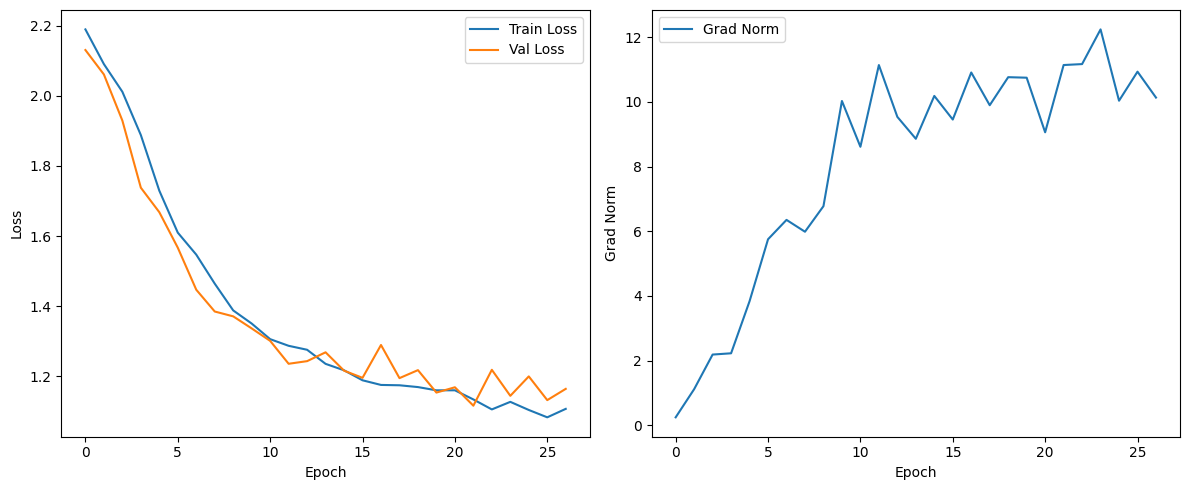

Accuracy: 0.5361
Classification Report:
               precision    recall  f1-score   support

           0       0.47      0.76      0.58        80
           1       0.74      0.62      0.68        80
           2       0.88      0.82      0.85        80
           3       0.56      0.25      0.34        80
           4       0.67      0.50      0.57        80
           5       0.40      0.39      0.39        80
           6       0.55      0.46      0.50        80
           7       0.44      0.53      0.48        80
           8       0.35      0.49      0.41        80

    accuracy                           0.54       720
   macro avg       0.56      0.54      0.53       720
weighted avg       0.56      0.54      0.53       720

Confusion Matrix:
 [[61  5  0  0  0  0  0 14  0]
 [18 50  8  0  0  0  0  4  0]
 [ 5  9 66  0  0  0  0  0  0]
 [ 2  2  0 20  1 12  8  7 28]
 [ 4  0  0  4 40  6 17  2  7]
 [ 2  0  0  5  0 31  0 15 27]
 [ 0  0  0  4 19  6 37  4 10]
 [27  2  0  0  0  8  0 42

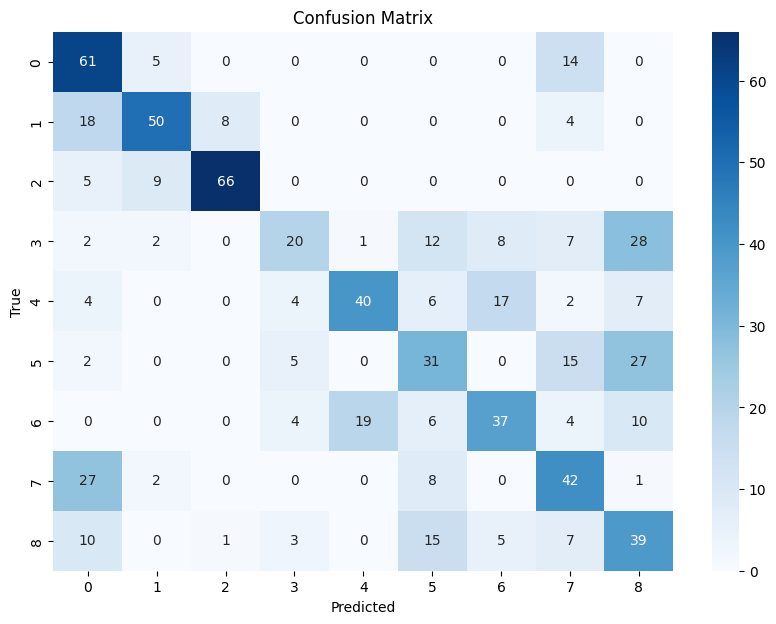

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Check if MPS is available and set the device
device = torch.device("cpu") #CPU as LSTM, sequential 
logging.info(f"Using device: {device}")

# Define the features and target
X = df.drop(columns=['Target', 'Timestamps'])
y = df['Target']
timestamps = df['Timestamps']

# Apply StandardScaler to the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Group the data by sequences based on the Timestamps column
sequences = []
current_sequence = []
current_labels = []
for i in range(len(X_scaled)):
    current_sequence.append(X_scaled[i])
    current_labels.append(y.iloc[i])
    if i < len(X_scaled) - 1 and timestamps.iloc[i + 1] == 0.0:
        sequences.append((current_sequence, current_labels))
        current_sequence = []
        current_labels = []
if current_sequence:
    sequences.append((current_sequence, current_labels))

# Ensure each sequence has the same length
sequence_length = max(len(seq[0]) for seq in sequences)
num_features = X.shape[1]

# Pad sequences to make them uniform in length
padded_sequences = []
padded_labels = []
for seq, labels in sequences:
    if len(seq) < sequence_length:
        padding = [[0] * num_features] * (sequence_length - len(seq))
        seq.extend(padding)
        labels.extend([labels[-1]] * (sequence_length - len(labels)))  # Pad labels with the last label
    padded_sequences.append(seq)
    padded_labels.append(labels)  # Use all labels for the sequence

# Convert sequences to a DataFrame
X_padded = np.array(padded_sequences)
y_padded = np.array(padded_labels)

# Flatten the labels to match the number of sequences
y_padded_flat = y_padded[:, 0]  # Use the first label of each sequence for simplicity

# Split the dataset
training_ratio = 0.8
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_padded_flat, test_size=(1 - training_ratio), stratify=y_padded_flat)

# One-hot encode the target variable
encoder = OneHotEncoder(sparse_output=False)
y_train_encoded = encoder.fit_transform(y_train.reshape(-1, 1))
y_test_encoded = encoder.transform(y_test.reshape(-1, 1))

# Ensure the reshaped data has the correct number of samples
assert X_train.shape[0] == y_train_encoded.shape[0], "Mismatch in number of training samples"
assert X_test.shape[0] == y_test_encoded.shape[0], "Mismatch in number of test samples"

# Convert data to PyTorch tensors and move to device
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.float32).to(device)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMClassifier, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.dropout1 = nn.Dropout(0.1)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.dropout2 = nn.Dropout(0.1)
        self.lstm3 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        #self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x = self.dropout1(x)
        x, _ = self.lstm2(x)
        x = self.dropout2(x)
        x, _ = self.lstm3(x)
        x = self.fc(x[:, -1, :])
        #x = self.softmax(x)
        return x

# Hyperparameters
input_size = num_features  # Number of features per time step
hidden_size = 100
output_size = y_train_encoded.shape[1]
num_epochs = 50
learning_rate = 0.001
early_stopping_patience = 5

# Initialize the model, loss function, and optimizer
model = LSTMClassifier(input_size, hidden_size, output_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop with early stopping
history = {'train_loss': [], 'val_loss': [], 'grad_norm': []}
best_loss = float('inf')
epochs_no_improve = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    grad_norms = []
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, torch.max(y_batch, 1)[1])
        loss.backward()

        # Calculate gradient norm
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        grad_norms.append(grad_norm.item())

        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    avg_grad_norm = np.mean(grad_norms)
    history['train_loss'].append(avg_train_loss)
    history['grad_norm'].append(avg_grad_norm)

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, torch.max(y_batch, 1)[1])
            val_loss += loss.item()

    avg_val_loss = val_loss / len(test_loader)
    history['val_loss'].append(avg_val_loss)

    info_str = (f"Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, "
                f"Val Loss: {avg_val_loss:.4f}, Grad Norm: {avg_grad_norm:.4f}")
    logging.info(info_str)
    print(info_str)

    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        logging.info("Best model saved.")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= early_stopping_patience:
        logging.info("Early stopping triggered.")
        break

# Plot training curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history['grad_norm'], label='Grad Norm')
plt.xlabel('Epoch')
plt.ylabel('Grad Norm')
plt.legend()
plt.tight_layout()
plt.show()

# Evaluate the model and obtain probability predictions using softmax
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    # Apply softmax to get probabilities for each class
    y_pred_probs = torch.softmax(y_pred, dim=1).cpu().numpy()
    # Ground truth is already one-hot encoded in y_test_tensor
    y_true = y_test_tensor.cpu().numpy()

# Compute ROC curve and AUC for each class using one-vs-rest approach
n_classes = y_true.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for every class on one plot
plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap('Set1', n_classes)
for i, class_name in enumerate(encoder.categories_[0]):  # using original class names
    plt.plot(fpr[i], tpr[i], color=colors(i), lw=2,
             label=f'ROC for {class_name} (AUC = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curves')
plt.legend(loc='lower right')
plt.show()

# For the confusion matrix and classification report, convert predictions to class indices
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_test_classes = np.argmax(y_true, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Print the classification report with original class names
print("Classification Report:\n", 
      classification_report(y_test_classes, y_pred_classes, target_names=encoder.categories_[0]))

# Plot the confusion matrix with real class names on the axes
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=encoder.categories_[0],
            yticklabels=encoder.categories_[0])
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()


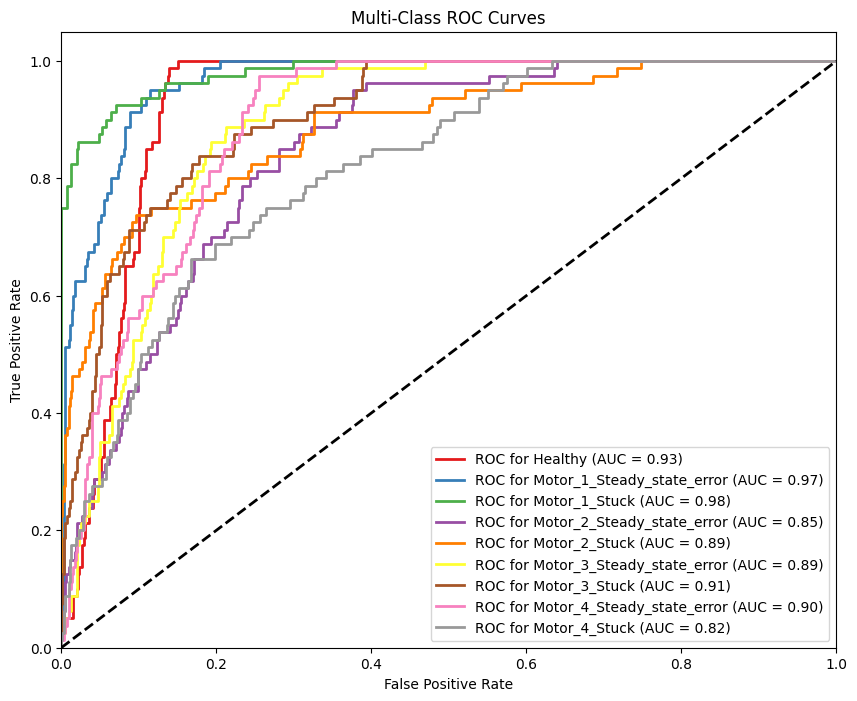

Classification Report:
                             precision    recall  f1-score   support

                   Healthy       0.47      0.76      0.58        80
Motor_1_Steady_state_error       0.74      0.62      0.68        80
             Motor_1_Stuck       0.88      0.82      0.85        80
Motor_2_Steady_state_error       0.56      0.25      0.34        80
             Motor_2_Stuck       0.67      0.50      0.57        80
Motor_3_Steady_state_error       0.40      0.39      0.39        80
             Motor_3_Stuck       0.55      0.46      0.50        80
Motor_4_Steady_state_error       0.44      0.53      0.48        80
             Motor_4_Stuck       0.35      0.49      0.41        80

                  accuracy                           0.54       720
                 macro avg       0.56      0.54      0.53       720
              weighted avg       0.56      0.54      0.53       720



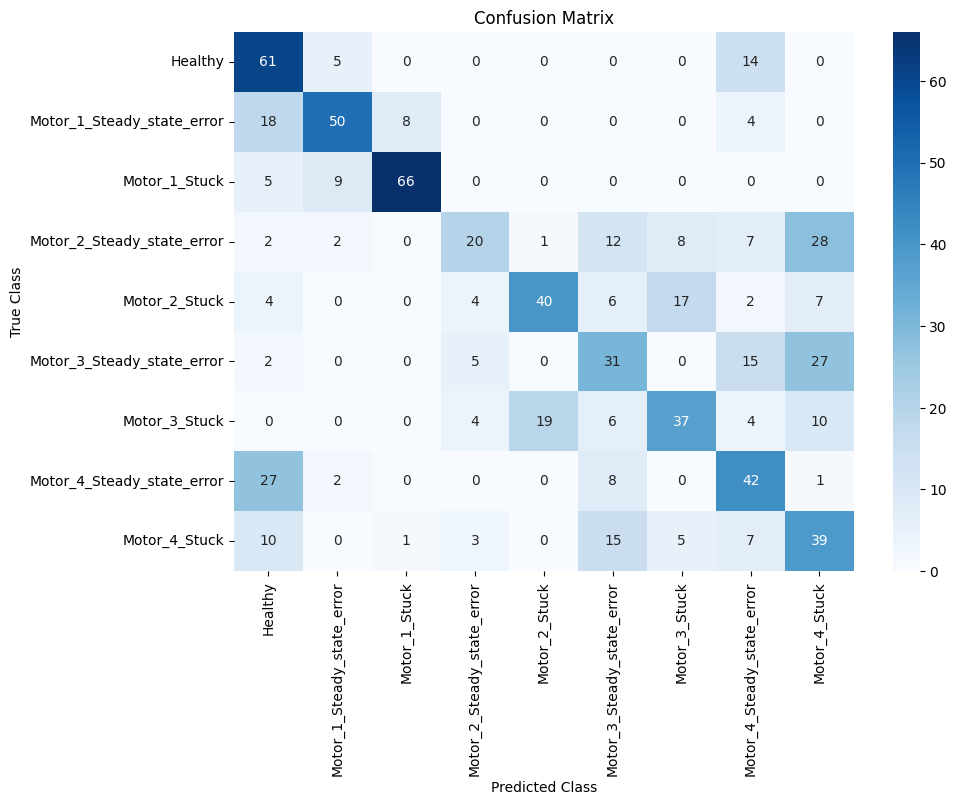

Weighted F1 Score: 0.5343703575320639


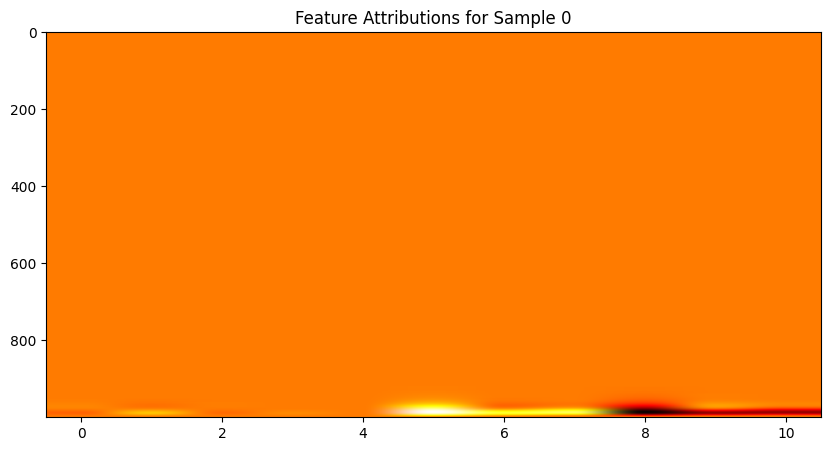

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from captum.attr import IntegratedGradients
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, f1_score
import seaborn as sns

# Evaluate the model and obtain probability predictions using softmax
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    # Apply softmax to get probabilities for each class
    y_pred_probs = torch.softmax(y_pred, dim=1).cpu().numpy()
    # Ground truth is already one-hot encoded in y_test_tensor
    y_true = y_test_tensor.cpu().numpy()

# Compute ROC curve and AUC for each class using one-vs-rest approach
n_classes = y_true.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for every class on one plot
plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap('Set1', n_classes)
for i, class_name in enumerate(encoder.categories_[0]):  # using original class names
    plt.plot(fpr[i], tpr[i], color=colors(i), lw=2,
             label=f'ROC for {class_name} (AUC = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curves')
plt.legend(loc='lower right')
plt.show()

# For the confusion matrix and classification report, convert predictions to class indices
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_test_classes = np.argmax(y_true, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Print the classification report with original class names
print("Classification Report:\n",
      classification_report(y_test_classes, y_pred_classes, target_names=encoder.categories_[0]))

# Plot the confusion matrix with real class names on the axes
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=encoder.categories_[0],
            yticklabels=encoder.categories_[0])
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()

# Print F1 Score (weighted)
f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')
print("Weighted F1 Score:", f1)


